In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import matplotlib.patches as patches

def find_gl_file(folder_path):
    # List all files in the specified folder
    for file in os.listdir(folder_path):
        # Check if the file starts with "GL"
        if file.startswith("GL"):
            return file
    return None

def find_boxes(folder):
    boxes = os.path.join(folder, 'Box.txt')
    with open(boxes, "r") as file:
        content = file.read()
    return content

def img_info(im):
    print(f'type: {type(im)}, dtype: {im.dtype}, shape: {im.shape}, min: {np.min(im)}, max: {np.max(im)}')

def dark_count(folder):
    filename = os.path.join(folder, 'AnalyzedClickInfo.txt')
    with open(filename, 'r') as file:
        for current_line_num, line in enumerate(file, start=1):
            if current_line_num == 33:
                bias_level = float(line.split()[-1])
                break
    return bias_level

def tensile(folder, id):
    filename = os.path.join(folder, 'Tensile.txt')
    with open(filename, 'r') as file:
        for current_line_num, line in enumerate(file, start=1):
            if current_line_num == id:
                if len(line.split()) < 3:
                    tensile_t = 0
                    tensile_s = 0
                else:
                    assert len(line.split()) == 3
                    tensile_t = float(line.split()[-2])
                    tensile_s = float(line.split()[-1])
                break
    return tensile_t, tensile_s

def blackbg(xlabel='', ylabel=''):
    plt.xlabel(xlabel, color='white', fontsize=20)
    plt.ylabel(ylabel, color='white', fontsize=20)
    plt.tick_params(axis='x', colors='white')
    plt.tick_params(axis='y', colors='white')
    plt.tick_params(axis='both', which='major', labelsize=20, colors='white')
    plt.gca().spines['top'].set_color('white')
    plt.gca().spines['right'].set_color('white')
    plt.gca().spines['left'].set_color('white')
    plt.gca().spines['bottom'].set_color('white')
    plt.gca().set_facecolor("none")
            
folders = [f.name for f in os.scandir() if f.is_dir()]
folders = sorted(folders, reverse=True)

In [2]:
mice = []

template = {
    "Cage": "",
    "ID": "",
    "Body": 0,
    "Tail": 0,
    "Tail_avg": 0,
    "Tail_t": 0,
    "Spine_t": 0
}

mouse_idx = ['X', 'R', 'L', 'RR', 'RL']
control_cage = ["BP", "DU", "EN"]
infected_cage = ["BI", "AQ", "EZ"]
for folder in folders:
    print(folder)
    bias_level = dark_count(folder)
    with open(os.path.join(folder, 'Box.txt'), "r") as file:
        for line in file:
            numbers = line.strip().split()
            arr = [int(num) for num in numbers]
            if len(arr) > 1:
                assert len(arr) == 10
                mouse = template.copy()
                mouse["Cage"] = folder.split('_')[-1].split('-')[0]
                mouse["ID"] = f'{mouse_idx[arr[0]-1]} ({str(arr[0])})'
                GT = cv2.imread(os.path.join(folder, find_gl_file(folder)))
                GT = cv2.cvtColor(GT, cv2.COLOR_BGR2RGB)
                photo = cv2.imread(os.path.join(folder, 'photograph.TIF'), -1)
                lumin = cv2.imread(os.path.join(folder, 'luminescent.TIF'), -1)
                lumin = lumin.astype(np.float32)
                if mouse["Cage"] in control_cage:
                    lumin[lumin>1000] = bias_level
                else:
                    assert mouse["Cage"] in infected_cage
                    lumin[lumin>5000] = bias_level
                mouse["Body"] = round(np.sum(lumin[arr[2]//2:arr[2]//2+arr[4]//2, arr[1]//2:arr[1]//2+arr[3]//2]-bias_level))
                mouse["Tail"] = round(np.sum(lumin[arr[6]//2:arr[6]//2+arr[8]//2, arr[5]//2:arr[5]//2+arr[7]//2]-bias_level))
                mouse["Tail_avg"] = round(mouse["Tail"]/arr[9], 2)
                mouse["Tail_t"], mouse["Spine_t"] = tensile(folder, arr[0])
                plt.figure(figsize=(25, 8))
                plt.subplot(131)
                plt.imshow(GT)
                plt.axis('off')
                plt.subplot(132)
                plt.imshow(photo, vmin=100, vmax=1500, cmap='gray')
                rect = patches.Rectangle((arr[1], arr[2]), arr[3], arr[4], linewidth=2, edgecolor='red', facecolor='none')
                plt.gca().add_patch(rect)
                rect = patches.Rectangle((arr[5], arr[6]), arr[7], arr[8], linewidth=2, edgecolor='red', facecolor='none')
                plt.gca().add_patch(rect)
                plt.axis('off')
                plt.subplot(133)
                plt.imshow(lumin, vmin=500, vmax=1500, cmap='gray')
                rect = patches.Rectangle((arr[1]//2, arr[2]//2), arr[3]//2, arr[4]//2, linewidth=2, edgecolor='red', facecolor='none')
                plt.gca().add_patch(rect)
                rect = patches.Rectangle((arr[5]//2, arr[6]//2), arr[7]//2, arr[8]//2, linewidth=2, edgecolor='red', facecolor='none')
                plt.gca().add_patch(rect)
                plt.axis('off')
                plt.show()
                plt.imshow(photo[arr[2]:arr[2]+arr[4], arr[1]:arr[1]+arr[3]], vmin=100, vmax=1500, cmap='gray')
                mice.append(mouse)
for mouse in mice:
    print(mouse)

In [3]:
import matplotlib.lines as mlines
import matplotlib.cm as cm

cmap = cm.get_cmap("bwr")

values = [np.log10(mouse['Body']) for mouse in mice if 'Body' in mouse]
values_max = np.max(values)
values_min = np.min(values)
for mouse in mice:
    mouse["Body_normalize"] = (np.log10(mouse['Body'])-values_min)/(values_max-values_min)

markersize_ = 600
fig, ax = plt.subplots(figsize=(7, 6))
for mouse in mice:
    if mouse["Tail_t"] > 0:
        # C3H
        if mouse['Cage'] in ['EN', 'BP', 'BI', 'EZ']:
            # 1y control
            if mouse['Cage'] == 'EN':
                plt.scatter(mouse["Tail_avg"], mouse["Tail_t"], s=markersize_, color=cmap(mouse["Body_normalize"]), edgecolor='gray', linewidth=4, marker='<')
            # 2y control
            if mouse['Cage'] == 'BP':
                plt.scatter(mouse["Tail_avg"], mouse["Tail_t"], s=markersize_, color=cmap(mouse["Body_normalize"]), edgecolor='gray', linewidth=4, marker='>')
            # 2y infected
            if mouse['Cage'] == 'BI':
                plt.scatter(mouse["Tail_avg"], mouse["Tail_t"], s=markersize_, color=cmap(mouse["Body_normalize"]), edgecolor='#8B6914', linewidth=4, marker='>')
            # 1y infected
            if mouse['Cage'] == 'EZ':
                plt.scatter(mouse["Tail_avg"], mouse["Tail_t"], s=markersize_, color=cmap(mouse["Body_normalize"]), edgecolor='#DAA520', linewidth=4, marker='<')
        # BL6
        else:    
            # uninfected
            if mouse['Cage'] == 'DU':
                plt.scatter(mouse["Tail_avg"], mouse["Tail_t"], s=markersize_, color=cmap(mouse["Body_normalize"]), edgecolor='gray', linewidth=4, marker='o')
            # infected
            if mouse['Cage'] == 'AQ':
                plt.scatter(mouse["Tail_avg"], mouse["Tail_t"], s=markersize_, color=cmap(mouse["Body_normalize"]), edgecolor='#8B6914', linewidth=4, marker='o')
norm = plt.Normalize(vmin=values_min, vmax=values_max)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Dummy array for ScalarMappable
# cbar = plt.colorbar(sm, label='Total Flux [p/sec]')  # Pass sm to plt.colorbar() for proper color mapping
# cbar.ax.yaxis.set_tick_params(labelsize=20)  # Tick color and size
# cbar.set_label('log Total Flux [p/sec]', fontsize=20)  # Label color and size

custom_legend_labels = ['C3H 1y Control', 'C3H 1y Infected', 'C3H 2y Control', 'C3H 2y Infected', 'BL6 2y Control', 'BL6 2y Infected']
custom_legend_colors = ['none', 'none', 'none', 'none', 'none', 'none']  # Colors for legend markers
custom_edgecolors = ['gray', '#DAA520', 'gray', '#8B6914', 'gray', '#8B6914']  # Colors for legend markers
custom_markers = ['<', '<', '>', '>', 'o', 'o']  # Different markers for each legend entry

# Create custom legend markers using Line2D
legend_markers = [
    mlines.Line2D([], [], color=color, markeredgecolor=edgecolor, marker=marker, markeredgewidth = 4, linestyle='None', markersize=22, label=label)
    for color, edgecolor, marker, label in zip(custom_legend_colors, custom_edgecolors, custom_markers, custom_legend_labels)
]

# Add custom legend to plot
legend = plt.legend(handles=legend_markers, fontsize=20, loc='upper right')
legend.get_frame().set_facecolor('white')  # Set background to transparent
legend.get_frame().set_edgecolor('none')  # Remove legend border
plt.axhline(y=7, xmin=0, xmax = 0.38, color='grey', linestyle='--', linewidth=2)
plt.axvline(x=4, color='grey', linestyle='--', linewidth=2)
ax.yaxis.set_ticks_position('right')
ax.yaxis.set_label_position('right')
plt.xticks([0, 10, 20, 30])
plt.xlabel('Average Flux of Tail [p/sec/cm^2]', fontsize=20)
plt.ylabel('Tensile Strength of Tail [MPa]', fontsize=20)
plt.tick_params(axis='x')
plt.tick_params(axis='y')
plt.tick_params(axis='both', which='major', labelsize=20)
plt.gca().set_facecolor("none")

plt.figure(figsize=(7, 6))
cbar = plt.colorbar(sm, label='Total Flux [p/sec]')  # Pass sm to plt.colorbar() for proper color mapping
cbar.ax.yaxis.set_tick_params(labelsize=20)  # Tick color and size
cbar.set_label('log Total Flux [p/sec]', fontsize=20)  # Label color and size


KeyboardInterrupt: 

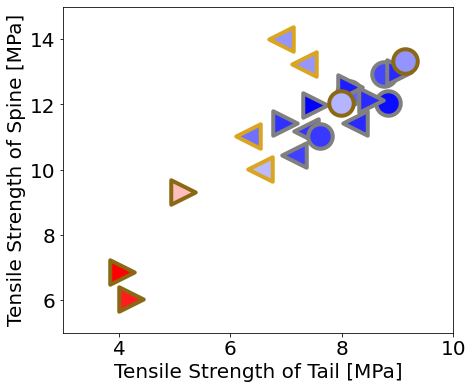

In [4]:

fig, ax = plt.subplots(figsize=(7, 6))
for mouse in mice:
    if mouse["Tail_t"] > 0:
        # C3H
        if mouse['Cage'] in ['EN', 'BP', 'BI', 'EZ']:
            # 1y control
            if mouse['Cage'] == 'EN':
                plt.scatter(mouse["Tail_t"], mouse["Spine_t"], s=markersize_, color=cmap(mouse["Body_normalize"]), edgecolor='gray', linewidth=4, marker='<')
            # 2y control
            if mouse['Cage'] == 'BP':
                plt.scatter(mouse["Tail_t"], mouse["Spine_t"], s=markersize_, color=cmap(mouse["Body_normalize"]), edgecolor='gray', linewidth=4, marker='>')
            # 2y infected
            if mouse['Cage'] == 'BI':
                plt.scatter(mouse["Tail_t"], mouse["Spine_t"], s=markersize_, color=cmap(mouse["Body_normalize"]), edgecolor='#8B6914', linewidth=4, marker='>')
            # 1y infected
            if mouse['Cage'] == 'EZ':
                plt.scatter(mouse["Tail_t"], mouse["Spine_t"], s=markersize_, color=cmap(mouse["Body_normalize"]), edgecolor='#DAA520', linewidth=4, marker='<')
        # BL6
        else:    
            # uninfected
            if mouse['Cage'] == 'DU':
                plt.scatter(mouse["Tail_t"], mouse["Spine_t"], s=markersize_, color=cmap(mouse["Body_normalize"]), edgecolor='gray', linewidth=4, marker='o')
            # infected
            if mouse['Cage'] == 'AQ':
                plt.scatter(mouse["Tail_t"], mouse["Spine_t"], s=markersize_, color=cmap(mouse["Body_normalize"]), edgecolor='#8B6914', linewidth=4, marker='o')
norm = plt.Normalize(vmin=values_min, vmax=values_max)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Dummy array for ScalarMappable
# cbar = plt.colorbar(sm, label='Total Flux [p/sec]')  # Pass sm to plt.colorbar() for proper color mapping
# cbar.ax.yaxis.set_tick_params(labelsize=20)  # Tick color and size
# cbar.set_label('log Total Flux [p/sec]', fontsize=20)  # Label color and size

custom_legend_labels = ['C3H 1y Control', 'C3H 1y Infected', 'C3H 2y Control', 'C3H 2y Infected', 'BL6 2y Control', 'BL6 2y Infected']
custom_legend_colors = ['none', 'none', 'none', 'none', 'none', 'none']  # Colors for legend markers
custom_edgecolors = ['gray', '#DAA520', 'gray', '#8B6914', 'gray', '#8B6914']  # Colors for legend markers
custom_markers = ['<', '<', '>', '>', 'o', 'o']  # Different markers for each legend entry

# Create custom legend markers using Line2D
legend_markers = [
    mlines.Line2D([], [], color=color, markeredgecolor=edgecolor, marker=marker, markeredgewidth = 4, linestyle='None', markersize=22, label=label)
    for color, edgecolor, marker, label in zip(custom_legend_colors, custom_edgecolors, custom_markers, custom_legend_labels)
]

# Add custom legend to plot
# legend = plt.legend(handles=legend_markers, fontsize=20, loc='upper right')
# legend.get_frame().set_facecolor('white')  # Set background to transparent
# legend.get_frame().set_edgecolor('none')  # Remove legend border
# plt.axhline(y=7, xmin=0, xmax = 0.38, color='grey', linestyle='--', linewidth=2)
# plt.axvline(x=4, color='grey', linestyle='--', linewidth=2)
# ax.yaxis.set_ticks_position('right')
# ax.yaxis.set_label_position('right')
plt.xlim([3, 10])
plt.ylim([5, 15])
plt.xlabel('Tensile Strength of Tail [MPa]', fontsize=20)
plt.ylabel('Tensile Strength of Spine [MPa]', fontsize=20)
plt.tick_params(axis='x')
plt.tick_params(axis='y')
plt.tick_params(axis='both', which='major', labelsize=20)
plt.gca().set_facecolor("none")

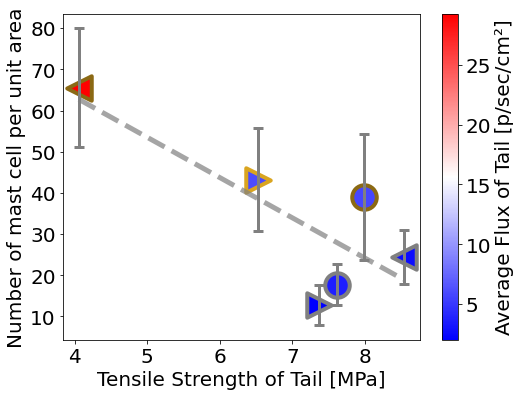

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Example data
data = [
    {'Tail_avg': 2.69, 'Tail_t': 8.53, 'mast_cell': np.array([14, 32, 25, 27]), 'color': 'gray', 'shape': '<'},
    {'Tail_avg': 29.29, 'Tail_t': 4.06, 'mast_cell': np.array([76, 80, 63, 43]), 'color': '#8B6914', 'shape': '<'},
    {'Tail_avg': 2.01, 'Tail_t': 7.36, 'mast_cell': np.array([13, 18, 15, 5]), 'color': 'gray', 'shape': '>'},
    {'Tail_avg': 6.07, 'Tail_t': 6.53, 'mast_cell': np.array([55, 52, 43, 23]), 'color': '#DAA520', 'shape': '>'},
    {'Tail_avg': 3.64, 'Tail_t': 7.62, 'mast_cell': np.array([26, 14, 17, 14]), 'color': 'gray', 'shape': 'o'},
    {'Tail_avg': 5.83, 'Tail_t': 7.99, 'mast_cell': np.array([62, 32, 42, 20]), 'color': '#8B6914', 'shape': 'o'}
]

# Extract data for fitting
x_vals = np.array([d['Tail_t'] for d in data])
y_vals = np.array([np.mean(d['mast_cell']) for d in data])

# Linear fit
slope, intercept = np.polyfit(x_vals, y_vals, 1)
x_fit = np.linspace(min(x_vals), max(x_vals), 100)
y_fit = slope * x_fit + intercept

# Get Tail_avg range for normalization
tail_avgs = [d['Tail_avg'] for d in data]
vmin, vmax = min(tail_avgs), max(tail_avgs)

plt.figure(figsize=(8, 6))
for d in data:
    x = d['Tail_t']
    y = np.mean(d['mast_cell'])
    yerr = np.std(d['mast_cell'])
    edge_color = d['color']
    marker_shape = d['shape']
    face_color = d['Tail_avg']
    plt.scatter(
        x, y, 
        c=[face_color], cmap='bwr', vmin=vmin, vmax=vmax,
        s=600, edgecolors=edge_color, marker=marker_shape, linewidth=4
    )
    plt.errorbar(x, y, yerr=yerr, fmt='none', ecolor='gray', capsize=5, elinewidth=3, capthick=3)

# Fitted line
plt.plot(x_fit, y_fit, linestyle='--', color='gray', alpha=0.7, linewidth=5, label='Linear Fit')

# Colorbar
sm = plt.cm.ScalarMappable(cmap='bwr', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.ax.yaxis.set_tick_params(labelsize=20)
cbar.set_label('Average Flux of Tail [p/sec/cm²]', fontsize=20)

plt.xlabel('Tensile Strength of Tail [MPa]', fontsize=20)
plt.ylabel('Number of mast cell per unit area', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.gca().set_facecolor("none")
plt.show()
